In [1]:
"""Sandbox module."""

import numpy as np
from data_generation import (
    gen_discretized_distributions,
    gen_grids_and_parameters,
)

from misc import (
    riemann_sum_arrays,
    trunc_norm_pdf,
    cdf_from_density,
    quantile_from_density,
)

%matplotlib inline

from scipy.stats import truncnorm

import warnings
warnings.filterwarnings("always")
from scipy.integrate import quad
from scipy.interpolate import interp1d, UnivariateSpline, CubicSpline

import matplotlib.pyplot as plt

In [2]:
def riemann_sum_arrays(support_grid, array, axis=-1, cumsum=False):
    """Computes the Riemann sum using the Midpoint rule for the given array, along
    the axis that contains the grid of values."""
    
    # Calculate the step size between consecutive grid points
    step_sizes = np.diff(support_grid)
    
    # Calculate midpoints
    midpoints = (support_grid[..., 1:] + support_grid[..., :-1]) / 2
    
    # Sample the function at the midpoints
    if array.ndim > 1:
        midpoint_values = np.zeros((array.shape[0], array.shape[-1] - 1))
        for i in range(len(midpoint_values)):
            midpoint_values[i] = np.interp(midpoints, support_grid, array[i])
    else:
        midpoint_values = np.interp(midpoints, support_grid, array)
    
    # Compute the cumulative sum along the specified axis (i.e.,
    # the integral up to each grid point)
    if cumsum:
        result = np.cumsum(midpoint_values * step_sizes, axis=axis)
        # Append last value so we have same shape as before
        result = np.append(result, result[..., -1][..., np.newaxis], axis=-1)
    # Or just the integral
    else:
        result = np.sum(midpoint_values * step_sizes, axis=axis)
    return result


In [3]:
def dens_from_qd(qd, qdsup=None, dsup=None):
    """Compute density from a quantile density function.

    'Inspired' from qd2dens in fdadensity package in R.

    """
    # Validate input
    eps = 1e-3
    boundaries = [np.min(qdsup), np.max(qdsup)]
    if not np.allclose(boundaries, [0, 1], atol=eps):
        msg = f"Please check the support of the QF domain's boundaries: {boundaries}"
        raise ValueError(msg)

    integral_qd = riemann_sum_arrays(qdsup, array=qd, axis=-1, cumsum=True)
    if not np.isclose(integral_qd[-1], np.ptp(dsup), atol=eps):
        msg = (
            "Quantile Density does not integrate to the range of the densities with "
            f"tolerance {eps}."
            f"\n Integral is: {integral_qd[...,-1]}"
            f"\n Range is: {np.ptp(dsup)}"
        )
        raise ValueError(msg)

    # Calculate new support grid
    dsup_temp = dsup[0] + integral_qd

    # Calculate density
    dens_temp = 1 / qd
    idx_unique = np.unique(dsup_temp, return_index=True, axis=-1)[1]
    dsup_temp = dsup_temp[..., idx_unique] 
    dens_temp = dens_temp[..., idx_unique]
    dens = np.interp(dsup, dsup_temp, dens_temp)

    if dens.ndim > 1:
        dens = np.zeros(qd.shape)
        for i in range(len(dens)):
            temp_sup, ind = np.unique(dsup_temp[i], return_index=True)
            temp = dens_temp[i][..., ind]
            dens[i] = CubicSpline(temp_sup, temp, bc_type="natural", axis=-1)(dsup)
    else:
        temp_sup, ind = np.unique(dsup_temp, return_index=True)
        temp = dens_temp[..., ind]
        print(ind.shape, temp_sup.shape, temp.shape)
        qd = CubicSpline(temp_sup, temp, bc_type="natural", axis=-1)(dsup)

    # Normalize the density
    dens /= riemann_sum_arrays(dsup, dens, axis=-1, cumsum=False)[..., np.newaxis]

    return dens

In [4]:
def qd_from_dens(dens, dsup=None, qdsup=None):
    """Compute quantile densities directly from densities.

    'Inspired' from dens2qd in fdadensity package in R.

    """
    # Validate input
    eps = 1e-3
    boundaries = [np.min(qdsup), np.max(qdsup)]
    if not np.allclose(boundaries, [0, 1], atol=eps):
        msg = f"Please check the support of the QF domain's boundaries: {boundaries}"
        raise ValueError(msg)

    integral_dens = riemann_sum_arrays(dsup, array=dens, axis=-1, cumsum=True)
    deviations_from_1 = abs(integral_dens[...,-1] - 1)
    if np.any(deviations_from_1 > eps):
        warnings.warn(
            f"Not all provided densities integrate to 1 with tolerance {eps}!"
            f"\n Max case of deviation is: {deviations_from_1.max()}"
            f"\n In position: {deviations_from_1.argmax()} "
            "\n Performing normalization...",
        )
        dens /= integral_dens[...,-1][..., np.newaxis]

    # spline = CubicSpline(dsup, dens, bc_type="natural", axis=-1)
    # qdsup_temp = riemann_sum_arrays(dsup, array=spline(dsup), axis=-1, cumsum=True)
    qdsup_temp = integral_dens
    
    qd_temp = 1 / dens

    # qd = CubicSpline(qdsup_temp, qd_temp, bc_type="natural", axis=-1)(qdsup)
    if dens.ndim > 1:
        qd = np.zeros(dens.shape)
        for i in range(len(qd)):
            temp_sup, ind = np.unique(qdsup_temp[i], return_index=True)
            temp = qd_temp[i][..., ind]
            qd[i] = CubicSpline(temp_sup, temp, bc_type="natural", axis=-1)(qdsup)
    else:
        temp_sup, ind = np.unique(qdsup_temp, return_index=True)
        temp = qd_temp[..., ind]
        qd = CubicSpline(temp_sup, temp, bc_type="natural", axis=-1)(qdsup)

    integral_qd = riemann_sum_arrays(qdsup, qd, axis=-1, cumsum=False)
    # integral_qd = np.trapz(qd, qdsup) / 2
    qd *= np.ptp(dsup) / integral_qd[..., np.newaxis]

    return qd

In [5]:
def gen_discretized_distributions(grid_pdfs, grid_qfs, mus, sigmas, truncation_point):
    """Generate discretized pdfs, cdfs, qfs, and qdfs."""
    # Truncated pdfs
    pdfs_discretized = trunc_norm_pdf(
        grid_pdfs[:, np.newaxis],
        mus,
        sigmas,
        -truncation_point,
        truncation_point,
    )

    # Truncated cdfs
    cdfs_discretized = cdf_from_density(
        grid_pdfs,
        pdfs_discretized,
        axis=-1,
    )

    # Truncated qfs
    qfs_discretized = quantile_from_density(
        pdfs_discretized,
        grid_pdfs,
        grid_qfs,
    )

    # Truncated qdfs
    qdfs_discretized = qd_from_dens(
        pdfs_discretized, dsup=grid_pdfs, qdsup=grid_qfs,
    )

    return pdfs_discretized, cdfs_discretized, qfs_discretized, qdfs_discretized

In [27]:
# Set up data
n = 200
gridnum = 100000
truncation_point = 3

grid_pdfs, grid_qfs, mus, sigmas = gen_grids_and_parameters(
    n, gridnum, truncation_point, delta=0,
)

In [28]:
# Generate distributions
pdfs_discretized, cdfs_discretized, qfs_discretized, qdfs_discretized = (
    gen_discretized_distributions(grid_pdfs, grid_qfs, mus, sigmas, truncation_point)
)

c:\Coding\thesis_frechet_fda\src\frechet_fda\misc.py:71: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 0.006931738288216249
 In position: 40
 Performing normalization...
  warnings.warn(


In [40]:
dens_to_look_at = 10
a = qd_from_dens(pdfs_discretized[dens_to_look_at], grid_pdfs, grid_qfs)
b = dens_from_qd(a, grid_qfs, grid_pdfs)
sigmas[:100]

(99999,) (99999,) (99999,)


array([0.45911424, 0.45864972, 0.90992458, 0.3375287 , 1.31826074,
       0.26744027, 4.07101118, 0.39391739, 3.16604967, 3.5862195 ,
       0.77923288, 0.70260489, 3.46450541, 2.73260279, 1.08003991,
       2.88153704, 0.43132887, 3.36330012, 0.36745186, 3.32576531,
       2.95576252, 0.51035996, 2.05384325, 1.14539278, 3.08158619,
       0.60214834, 0.2536017 , 1.68013611, 0.25792684, 1.2317736 ,
       0.24518631, 2.59606102, 1.58972153, 2.51606012, 0.26842178,
       0.47440702, 1.7194298 , 1.33425308, 0.56430942, 0.26019163,
       4.32292592, 0.272001  , 0.83307769, 1.18737487, 1.10956896,
       2.43488465, 0.79499202, 2.4780775 , 0.33380072, 2.81517048,
       0.61183385, 0.6048098 , 0.71849035, 0.8794968 , 2.77580017,
       1.75357796, 2.11360221, 2.91372805, 1.15165871, 0.28577692,
       2.00003289, 2.95653858, 0.4546094 , 3.67334919, 2.69932858,
       1.10271312, 1.86954058, 0.48942658, 1.79193817, 0.50617283,
       0.55279198, 4.26979597, 0.24514208, 0.35627959, 1.16264

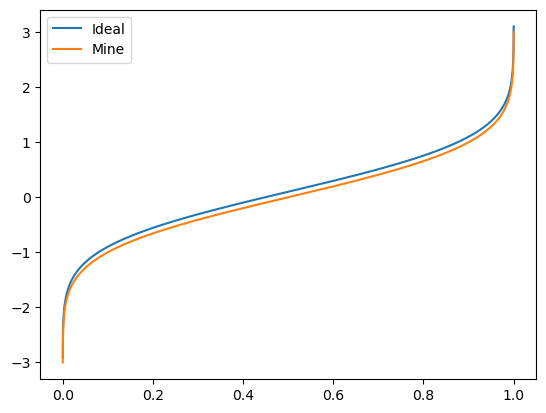

In [41]:
ideal_quantiles = truncnorm.ppf(grid_qfs, loc=0, scale=sigmas[dens_to_look_at], a=(-truncation_point /sigmas[dens_to_look_at]), b=(truncation_point /sigmas[dens_to_look_at]))
fig, ax = plt.subplots()
ax.plot(grid_qfs, ideal_quantiles + 0.1, label="Ideal")
ax.plot(grid_qfs, qfs_discretized[dens_to_look_at], label="Mine")
plt.legend()
plt.show()

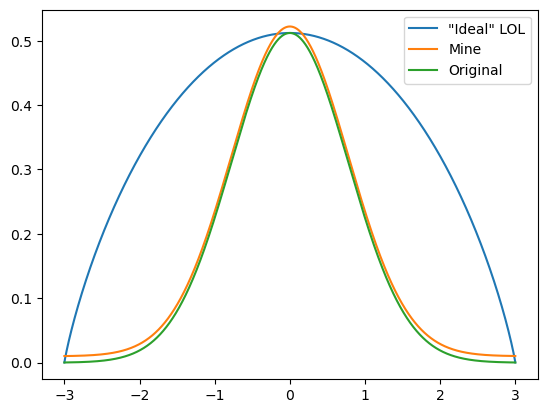

In [42]:
ideal_qdfs = truncnorm.pdf(ideal_quantiles, loc=0, scale=sigmas[dens_to_look_at], a=(-truncation_point /sigmas[dens_to_look_at]), b=(truncation_point /sigmas[dens_to_look_at]))
fig, ax = plt.subplots()
ax.plot(grid_pdfs, ideal_qdfs, label="\"Ideal\" LOL")
ax.plot(grid_pdfs, b + 0.01, label="Mine")
ax.plot(grid_pdfs, pdfs_discretized[dens_to_look_at], label="Original")
plt.legend()
plt.show()

In [43]:
riemann_sum_arrays(grid_qfs, a)

6.0

In [44]:
a[:5], a[-5:]

(array([3231.00432666, 2788.24059145, 2454.9723046 , 2194.81646543,
        1985.94193473]),
 array([1984.80413909, 2193.54995522, 2453.54442517, 2786.60447873,
        3229.08985885]))

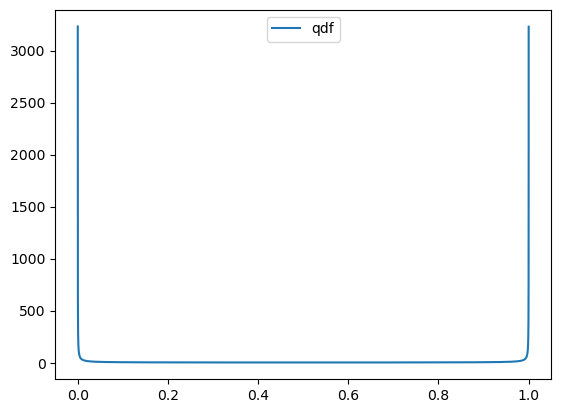

In [45]:
fig, ax = plt.subplots()
ax.plot(grid_qfs, a, label="qdf")
plt.legend()
plt.show()

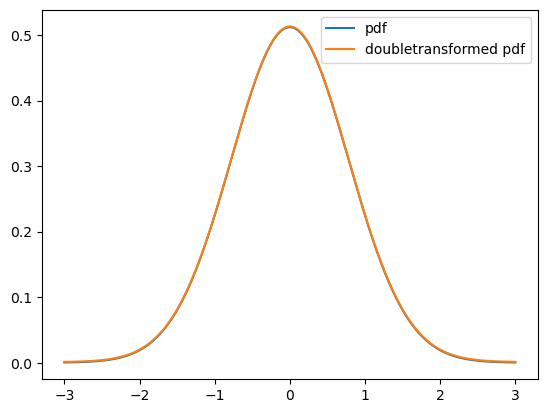

In [46]:
# Compare if pdf -> qdf -> pdf still looks like original pdf
fig, ax = plt.subplots()
ax.plot(grid_pdfs, pdfs_discretized[dens_to_look_at], label="pdf")
ax.plot(grid_pdfs, b + 0.001, label="doubletransformed pdf")
plt.legend()
plt.show()

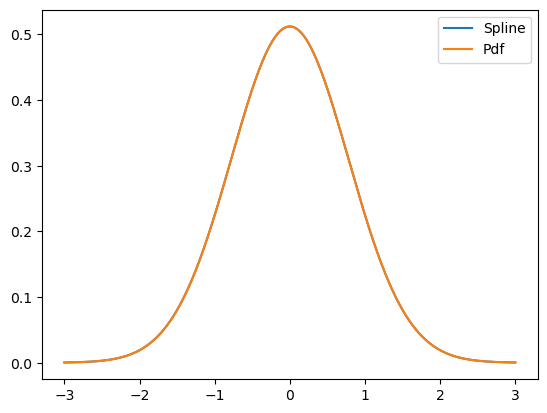

In [47]:
# Look how spline looks compared to usual distribution
fig, ax = plt.subplots()
ax.plot(grid_pdfs, CubicSpline(grid_pdfs, pdfs_discretized, axis=-1)(grid_pdfs)[dens_to_look_at], label="Spline")
ax.plot(grid_pdfs, pdfs_discretized[dens_to_look_at], label="Pdf")
plt.legend()
plt.show()

In [48]:
qdfs_discretized[0][499], pdfs_discretized[0][499]

(0.008872688745035604, 7.104211846410067e-10)

In [49]:
(np.log(qdfs_discretized[0]) + np.log(np.interp(qfs_discretized[0], grid_pdfs, pdfs_discretized[0])))

array([-8.18396656, -8.18481905, -8.18481905, ..., -8.18481905,
       -8.18481905, -8.18452631])

In [50]:
a = np.array([0,1,2,3,4])

In [51]:
np.cumsum(a)

array([ 0,  1,  3,  6, 10])